In [30]:
# from model import *
from torchsummary import summary
from Uformer_model import *

In [32]:
# model = UNet_1(n_channels=18, n_classes=1)
model = Uformer(img_size=64,embed_dim=32,win_size=8,in_chans=1,dd_in=18,token_projection='linear',token_mlp='leff',modulator=False)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [33]:
count_parameters(model)

20625851

In [48]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import glob
import wandb
from model import *
import argparse
import random
import numpy as np

In [4]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [5]:
run = wandb.init()

wandb: Currently logged in as: stmmc (tousi-team). Use `wandb login --relogin` to force relogin


In [87]:
artifact = run.use_artifact("tousi-team/Good-Gully-Detection-workers/model_epoch_200:v4", type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model_epoch_200:v4, 51.18MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:8.7


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
model = UNet_1(n_channels=18, n_classes=1, dropout_rate=0.5).to(device)

In [88]:
model.load_state_dict(torch.load('./artifacts/model_epoch_200:v4/model_epoch_200.pth'))

<All keys matched successfully>

In [11]:
in_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/rgb2so/rgb_data_64/'
tar_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/rgb2so/so_data_64/'

In [12]:
dataset = RGBStreamOrderDataset(input_dir=in_dir, target_dir=tar_dir, augment=True)

In [13]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [22]:
train_loader = DataLoader(train_dataset, batch_size=8, num_workers = 8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers = 8, shuffle=True)

In [19]:
def evaluate_model(model, dataloader, criterion, threshold=0.5, nottest=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("------ Evaluation --------")
    model.eval()
    total_loss = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Apply sigmoid function to ensure outputs are in the probability space
            probs = outputs.sigmoid()
            preds = (probs > threshold).float()  # Cast to float to perform calculations

            loss = criterion(outputs, targets)
            total_loss += loss.item()

            precision, recall, f1 = calculate_precision_recall_f1(preds, targets.float())
            total_precision += precision
            total_recall += recall
            total_f1 += f1

            if not nottest:
                break

    avg_loss = total_loss / num_batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_f1 = total_f1 / num_batches

    return avg_loss, avg_precision, avg_recall, avg_f1

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [25]:
avg_loss, avg_precision, avg_recall, avg_f1 = evaluate_model(model, test_loader, criterion, threshold=0.5, nottest=False)


------ Evaluation --------


  0%|                                                                                                                   | 0/1016 [00:00<?, ?it/s]


In [26]:
print(avg_loss, avg_precision, avg_recall, avg_f1)

0.00045673472909476816 0.0 tensor(0., device='cuda:0') 0.0


In [27]:
probs

NameError: name 'probs' is not defined

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("------ Evaluation --------")
model.eval()
total_loss = 0
total_precision = 0
total_recall = 0
total_f1 = 0
num_batches = len(test_loader)

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Apply sigmoid function to ensure outputs are in the probability space
#         probs = outputs.sigmoid()
        preds = (probs > 0.5).float()  #Cast to float to perform calculations

        loss = criterion(outputs, targets)
        total_loss += loss.item()

        precision, recall, f1 = calculate_precision_recall_f1(preds, targets.float())
        total_precision += precision
        total_recall += recall
        total_f1 += f1


        break

avg_loss = total_loss / num_batches
avg_precision = total_precision / num_batches
avg_recall = total_recall / num_batches
avg_f1 = total_f1 / num_batches

------ Evaluation --------


  0%|                                                                                                                   | 0/1016 [00:00<?, ?it/s]


In [116]:
outputs[0].min()

tensor(-3.9400, device='cuda:0')

In [124]:
targets[0]>0

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False,  True],
         ...,
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

In [104]:
recall

tensor(0.0004, device='cuda:0')

In [105]:
precision

tensor(0.0797, device='cuda:0')

In [96]:
index = 3

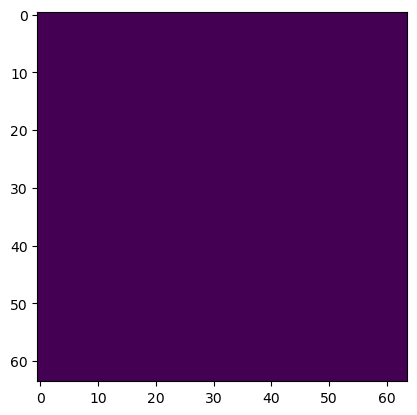

In [106]:
plt.imshow(preds[index].cpu().numpy().squeeze())

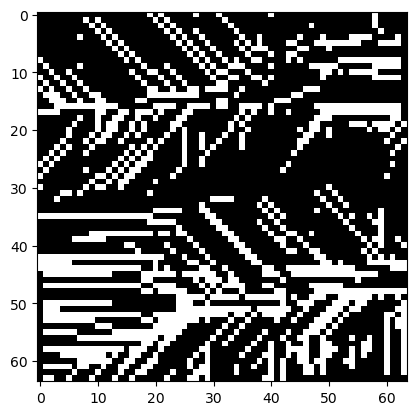

In [107]:
plt.imshow(targets[index].cpu().numpy().squeeze()>0, cmap='gray')

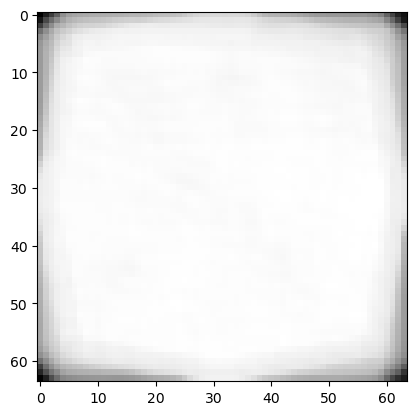

In [114]:
plt.imshow(outputs[index].cpu().numpy().squeeze(), cmap='gray')

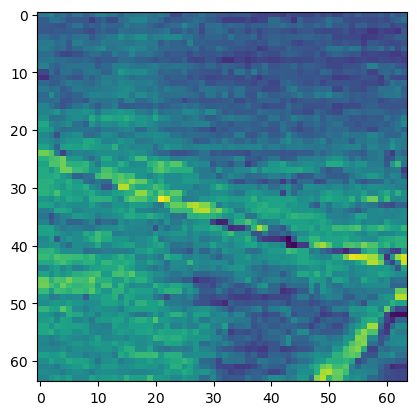

In [109]:
plt.imshow(inputs[index].cpu().numpy().squeeze()[1,:,:])